# Классификация: превышает ли CC50 медиану

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
# Загрузка и подготовка
df = pd.read_excel("Данные_для_курсовои_Классическое_МО.xlsx")
df = df.drop(columns=["Unnamed: 0"], errors='ignore')
df = df.dropna(subset=["CC50, mM"])

# Целевая переменная
threshold = df["CC50, mM"].median()
df["CC50_class"] = (df["CC50, mM"] > threshold).astype(int)

# Удалим таргеты и саму метку
X = df.drop(columns=["IC50, mM", "CC50, mM", "SI", "CC50_class"], errors='ignore')
y = df["CC50_class"]

# Классификация: бинаризация по медиане SI
threshold = y.median()
y_class = (y > threshold).astype(int)

# Заполнение NaN и нормализация
X = X.fillna(X.median(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Модели
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM (RBF)": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

# Оценка
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-score": f1,
        "ROC AUC": auc
    })

# Вывод результатов
results_df = pd.DataFrame(results).sort_values(by="F1-score", ascending=False)
print(results_df)

                 Model  Accuracy  F1-score   ROC AUC
1        Random Forest  0.810945  0.806122  0.880060
2    Gradient Boosting  0.805970  0.804020  0.882688
4                  KNN  0.776119  0.780488  0.849058
3            SVM (RBF)  0.771144  0.772277  0.855208
0  Logistic Regression  0.756219  0.763285  0.850347


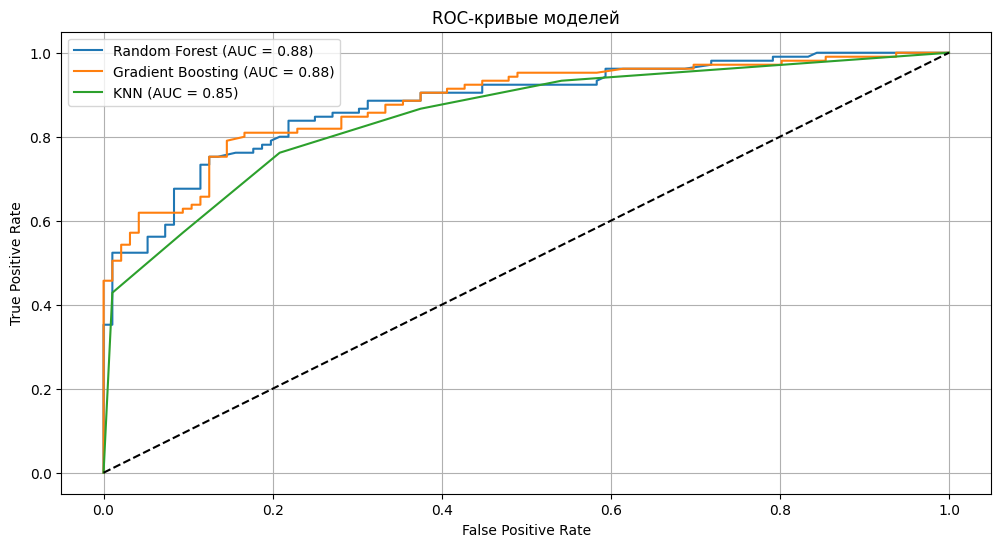

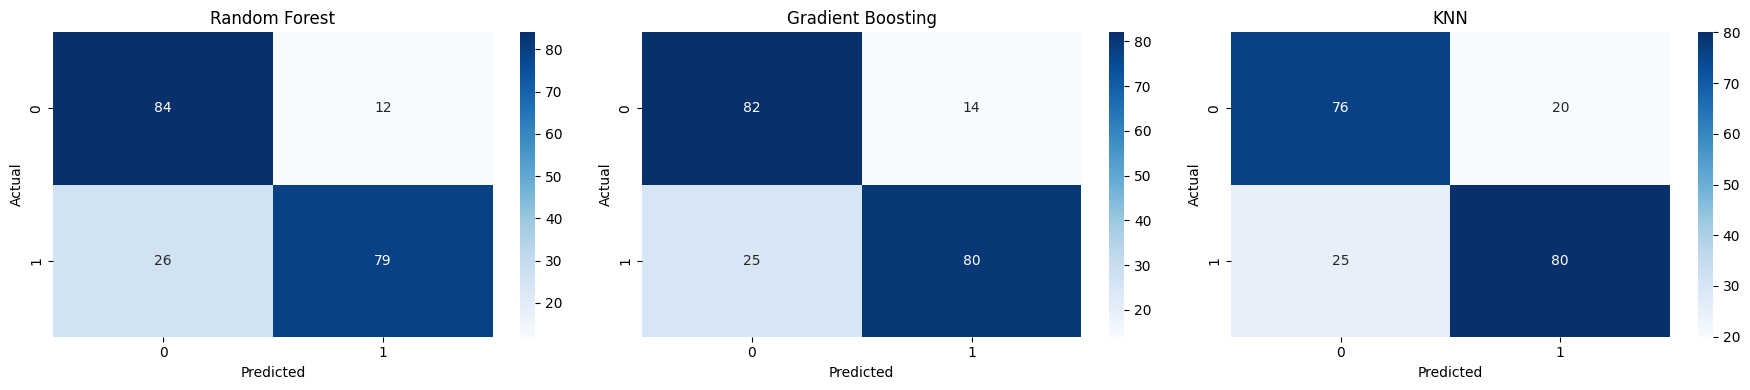

In [6]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    classification_report,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Модели
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

results = {}
plt.figure(figsize=(12, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Метрики
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "conf_matrix": cm,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc,
        "report": report
    }

    # ROC-кривая
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-кривые моделей")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Матрицы ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res["conf_matrix"], annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
plt.tight_layout()
plt.show()

# Таблица метрик
metrics_table = pd.DataFrame({
    name: {
        "Accuracy": res["report"]["accuracy"],
        "Precision": res["report"]["1"]["precision"],
        "Recall": res["report"]["1"]["recall"],
        "F1-Score": res["report"]["1"]["f1-score"],
        "AUC": res["roc_auc"]
    }
    for name, res in results.items()
}).T.round(3)

# Обучаю базовую модель Gradient Boosting

In [7]:
# Обучение базовой модели
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [8]:
# Предсказания и метрики
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)
auc_score = roc_auc_score(y_test, y_prob)

report["AUC"] = auc_score
report

{'0': {'precision': 0.7663551401869159,
  'recall': 0.8541666666666666,
  'f1-score': 0.8078817733990148,
  'support': 96.0},
 '1': {'precision': 0.851063829787234,
  'recall': 0.7619047619047619,
  'f1-score': 0.8040201005025126,
  'support': 105.0},
 'accuracy': 0.8059701492537313,
 'macro avg': {'precision': 0.808709484987075,
  'recall': 0.8080357142857142,
  'f1-score': 0.8059509369507637,
  'support': 201.0},
 'weighted avg': {'precision': 0.810605948187082,
  'recall': 0.8059701492537313,
  'f1-score': 0.8058644815874092,
  'support': 201.0},
 'AUC': np.float64(0.882688492063492)}

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Подбираю гиперпараметры для улучшения предсказания
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [10]:
# Извлекаем лучшие параметры
best_params = grid.best_params_

# Повторное обучение на лучших параметрах
final_model = GradientBoostingClassifier(random_state=42, **best_params)
final_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=200,
                           random_state=42, subsample=0.8)

In [11]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # если нужна вероятность для ROC/AUC

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

[[82 14]
 [25 80]]
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        96
           1       0.85      0.76      0.80       105

    accuracy                           0.81       201
   macro avg       0.81      0.81      0.81       201
weighted avg       0.81      0.81      0.81       201

AUC: 0.882688492063492


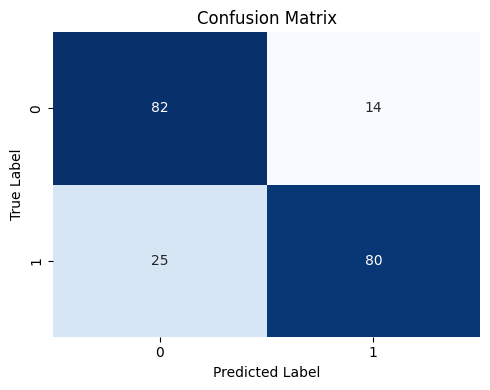

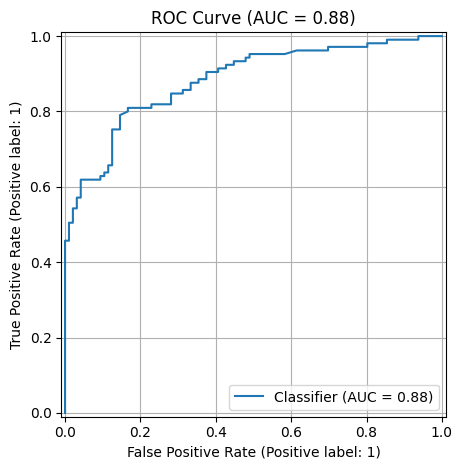

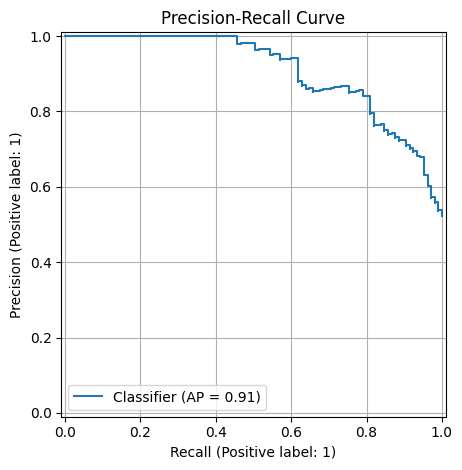

In [13]:
# Матрица ошибок (Confusion Matrix)
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ROC-кривая
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title(f"ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall кривая
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()